In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns

# Business Understanding

Let's try to analyze Data from Inside Airbnb Berlin to answer the following questions:
* Is 2020 a year like any other at airbnb?
* Can we find traces of COVID-19 in Inside Airbnb's data?
* Does COVID-19 infect the data?

Read the corresponding blog post at <https://medium.com/@sopka/covid-19-and-inside-airbnb-eb0d2da212ea>

# Data Understanding

In [2]:
# read in calendar data
calendar2020 = pd.read_csv('data/2020-01-10/unzipped/calendar.csv')

In [3]:
display(calendar2020) # show tabular overview of the data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2015,2020-01-11,f,$33.00,$33.00,5.0,1125.0
1,2015,2020-01-12,f,$33.00,$33.00,5.0,1125.0
2,2015,2020-01-13,f,$33.00,$33.00,5.0,1125.0
3,2015,2020-01-14,f,$33.00,$33.00,5.0,1125.0
4,2015,2020-01-15,f,$33.00,$33.00,5.0,1125.0
...,...,...,...,...,...,...,...
9252394,41453441,2021-01-05,f,$26.00,$26.00,4.0,1125.0
9252395,41453441,2021-01-06,f,$26.00,$26.00,4.0,1125.0
9252396,41453441,2021-01-07,f,$26.00,$26.00,4.0,1125.0
9252397,41453441,2021-01-08,f,$26.00,$26.00,4.0,1125.0


In [4]:
calendar2020.isnull().any() # check for any NaN values

listing_id        False
date              False
available         False
price              True
adjusted_price     True
minimum_nights     True
maximum_nights     True
dtype: bool

In [5]:
# ok there are null values, so show some of them...
display(calendar2020[calendar2020.isnull().any(axis=1)])
calendar2020[calendar2020.isnull().any(axis=1)].shape

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
2418809,11563150,2021-01-03,f,NaN,NaN,1.0,1125.0
2418810,11563150,2021-01-04,f,NaN,NaN,1.0,1125.0
2418811,11563150,2021-01-05,f,NaN,NaN,1.0,1125.0
2418812,11563150,2021-01-06,f,NaN,NaN,1.0,1125.0
2418813,11563150,2021-01-07,f,NaN,NaN,1.0,1125.0
2418814,11563150,2021-01-08,f,NaN,NaN,1.0,1125.0
2418815,11563150,2021-01-09,f,NaN,NaN,1.0,1125.0
5822441,25967543,2020-01-10,f,$40.00,$40.00,NaN,NaN
5822990,25969985,2020-01-10,f,$50.00,$50.00,NaN,NaN
9068513,40885548,2021-01-03,f,NaN,NaN,5.0,12.0


(16, 7)

## Data Preparation

In [6]:
# Since only a few rows have nan values, lets drop the ones specifically from the columns
# that are important for our analysis.

def drop_nan_calendar_values(calendar):
    '''
    Description: drops rows with NaN values from the columns price and minimum_nights.
    
    Arguments:
        calendar (pandas.DataFrame): a pandas DataFrame populated with calendar.csv 
                                     from Inside Airbnb.
    
    Returns:
        DataFrame: processed calender instance.
    '''
    calendar.dropna(subset=['price'], inplace=True)
    if 'minimum_nights' in calendar.columns:
        calendar.dropna(subset=['minimum_nights'], inplace=True)
    return calendar

calendar2020 = drop_nan_calendar_values(calendar2020)
calendar2020.isnull().any()

listing_id        False
date              False
available         False
price             False
adjusted_price    False
minimum_nights    False
maximum_nights    False
dtype: bool

In [7]:
type(calendar2020.date[0])

str

In [8]:
# convert date string values to timestamps for better comparison and grouping
def convert_dates(calendar):
    '''
    Description: converts the column date from type str to pandas.TimeStamp
    
    Arguments:
        calendar (pandas.DataFrame): a pandas DataFrame populated with calendar.csv 
                                     from Inside Airbnb.
    
    Returns:
        pandas.DataFrame: processed calender instance.
    '''
    calendar.date = calendar.date.apply(pd.Timestamp)
    return calendar

calendar2020 = convert_dates(calendar2020)

In [9]:
# check the assumption that for every day there is exactly one entry for each listing
# so lets first create a grouping consisting of (date,listing_id) pairs
cglid2020 = calendar2020.groupby(by=['date','listing_id']) # create pairs grouped by date and listing_id

In [10]:
count_date_listingid_pairs = cglid2020.price.count().count()
print("number of pairs", count_date_listingid_pairs)
print("number of pairs equals dataframe number of rows?", count_date_listingid_pairs==calendar2020.shape[0])
print("for every of these pairs there exists exactly 1 entry?", cglid2020.price.value_counts().mean()==1.000000)


number of pairs 9252383
number of pairs equals dataframe number of rows? True
for every of these pairs there exists exactly 1 entry? True


In [11]:
# if there is exactly 1 entry for each pair, do we have for each day the amount of unique listing ids?
count_unique_listings = calendar2020.listing_id.nunique()
print("number of unique listings ids is", count_unique_listings)
print("ration of pairs and unique listing ids is", count_date_listingid_pairs / count_unique_listings)

number of unique listings ids is 25349
ration of pairs and unique listing ids is 364.9999211014241


In [12]:
# The ratio of pairs and unique listing ids is not an integer, 
# so there must be an unequal distribution of number of listings per day
calendar2020.groupby('date').date.count() # .hist()

date
2020-01-10     3388
2020-01-11    25349
2020-01-12    25349
2020-01-13    25349
2020-01-14    25349
              ...  
2021-01-05    25347
2021-01-06    25347
2021-01-07    25347
2021-01-08    25347
2021-01-09    21971
Name: date, Length: 366, dtype: int64

In [13]:
# so there are days where we have no data for some listings
# lets define a function to remove those days in our analysis

def remove_days_with_less_entries(calendar):
    '''
    Description: removes all rows where the group of entries with the same date
                 are less then 20000
    
    Arguments:
        calendar (pandas.DataFrame): a pandas DataFrame populated with calendar.csv 
                                     from Inside Airbnb.
    
    Returns:
        pandas.DataFrame: processed calender instance.
    '''
    calendar = calendar[calendar.groupby('date').listing_id.transform('count') >= 20000]
    return calendar.copy()

calendar2020 = remove_days_with_less_entries(calendar2020)

Let's plot one calendar timeseries which can be seen as the forecast of the overall availability of accommodation. The overall availability is measured by the mean all entries for each day.

In [14]:
# before we can plot the mean of available accommodations we need to prepare our data.
# we need to convert the categorical column available to integers for which we e.g. can
# compute the mean.
# later in the analysis we need the day of the year, so we include it in this function for reuse

def prepare_columns_for_utilization(calendar):
    '''
    Description: creates a new column obtainable with converted values from the column
                 available with integers instead of booleans and creates a new column
                 dayofyear from the column date with the day of year value [1;365] instead
                 of a complete date type.
    
    Arguments:
        calendar (pandas.DataFrame): a pandas DataFrame populated with calendar.csv 
                                     from Inside Airbnb.
    
    Returns:
        pandas.DataFrame: processed calender instance.
    '''
    # first we transform the categorical values for the available indication from t/f to 0/1
    calendar['obtainable'] = calendar.available.map(lambda x: 1 if x == 't' else 0) # obtainable is synonym to available
    # when we plot functions for multiple years together we need just the day of the year
    calendar['dayofyear'] = calendar.date.dt.dayofyear # .strftime('%j').astype(int)
    return calendar

calendar2020 = prepare_columns_for_utilization(calendar2020)

<AxesSubplot:xlabel='date'>

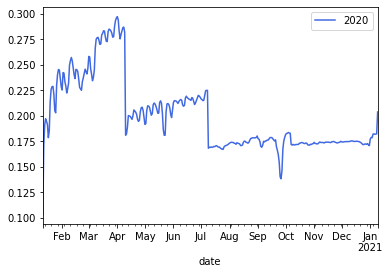

In [15]:
# plot the mean of availability
calendar2020.groupby('date').obtainable.mean().plot(label="2020", legend=True, color='royalblue')

Let's see how it matches the forecast/booking state of a few month ago in December 2019 and with a few more calendar datasets later in 2020...
So let's prepare new datasets for these time series:

In [16]:
def process_calendar(filename_or_calendar, drop_na=True):
    '''
    Description: combines multiple processing functions to manipulate the data of a pandas.DataFrame.
                 Called functions:
                 * drop_nan_calendar_values
                 * convert_dates
                 * remove_days_with_less_entries
                 * prepare_columns_for_utilization
    
    Arguments:
        filename_or_calendar (str or pandas.DataFrame): a filename to a calendar.csv file from Inside Airbnb
                                                        or an already loaded file as a pd.DataFrame 
        drop_na (bool): flag if NaN values should be dropped or not
    
    Returns:
        pandas.DataFrame: processed calender instance.
    '''
    if isinstance(filename_or_calendar, str):
        print('load csv file', filename_or_calendar)
        calendar = pd.read_csv(filename_or_calendar)
    elif isinstance(filename_or_calendar, pd.DataFrame):
        calendar = filename_or_calendar
    else:
        raise TypeError('argument is not of type ' + str(pd.DataFrame))
    if drop_na:
        calendar = drop_nan_calendar_values(calendar)
    calendar = convert_dates(calendar)
    calendar = remove_days_with_less_entries(calendar)
    calendar = prepare_columns_for_utilization(calendar)
    return calendar

In [17]:
calendar2019 = process_calendar('data/2019-12-11/unzipped/calendar.csv')

load csv file data/2019-12-11/unzipped/calendar.csv


In [18]:
calendar2020_04 = process_calendar('data/2020-04-17/unzipped/calendar.csv')

load csv file data/2020-04-17/unzipped/calendar.csv


In [19]:
calendar2020_07 = process_calendar('data/2020-06-13/unzipped/calendar.csv')

load csv file data/2020-06-13/unzipped/calendar.csv


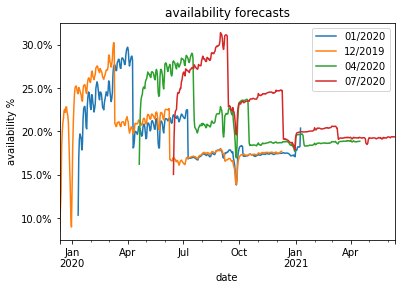

In [20]:
# and plot all of them together
ax = calendar2020.groupby('date').obtainable.mean().plot(label="01/2020", legend=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
calendar2019.groupby('date').obtainable.mean().plot(label="12/2019", legend=True)
calendar2020_04.groupby('date').obtainable.mean().plot(label="04/2020", legend=True)
calendar2020_07.groupby('date').obtainable.mean().plot(label="07/2020", legend=True)
plt.title('availability forecasts')
plt.xlabel('date')
plt.ylabel('availability %')
plt.gcf().savefig('availability_forcast.png', bbox_inches='tight') # https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.04-Saving-Plots/
plt.show()

It seems that the overall availability in 2020 is less than expected in 2019.
On the otherhand a lot of accommodations are booked spontanously so a 1 year prediction will always be inacurate.

But if we look at the datasets for January, April and July of 2020 we also see that a 2 month forecast is shifted to the right and there are more accomadations available than expected.

Let's make an educated guess: Is COVID19 the reason?

Maybe we'll also find hints about covid in the reviews and mark the beginning of covid19 in our diagram...

In [21]:
# read in reviews
reviews2020 = pd.read_csv('data/2020-08-30/unzipped/reviews.csv', converters={'date:': pd.Timestamp})

In [22]:
# find the first occurance of covid in the reviews
covid_mindate = reviews2020[reviews2020.comments.str.contains(pat='covid|coronavirus', case=False, regex=True, na=False)].date.min()
display(covid_mindate)

'2020-03-05'

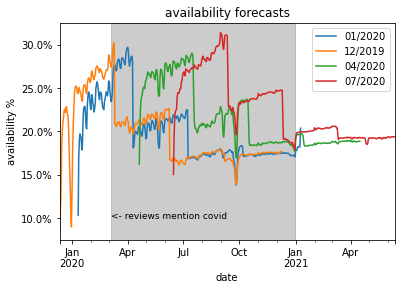

In [23]:
# and plot all of them together

ax = calendar2020.groupby('date').obtainable.mean().plot(label="01/2020", legend=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
calendar2019.groupby('date').obtainable.mean().plot(label="12/2019", legend=True)
calendar2020_04.groupby('date').obtainable.mean().plot(label="04/2020", legend=True)
calendar2020_07.groupby('date').obtainable.mean().plot(label="07/2020", legend=True)

# plot a gray underlay starting at the date covid was first mentioned
plt.axvspan(covid_mindate, pd.Timestamp("2021-01-01")-pd.Timedelta("1 days"), color='gray', alpha=0.4)
plt.title('availability forecasts')
plt.xlabel('date')
plt.ylabel('availability %')
plt.text(covid_mindate, 0.1, '<- reviews mention covid', fontsize=9)

plt.gcf().savefig('covid_min_date.png', bbox_inches='tight') # https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.04-Saving-Plots/
plt.show()

Let's find more evidence for our hypothesis that covid19 is the reason that after March 2020 there are more accomodations available as usual.

Since airbnb is giving us for each calendar several datasets with a forecast of 1 year, their time intervals overlap. We could try to aggregate all the calendar data for each year...

For this we read in all calendar datasets of a year and extract the rows from the time intervals between the scraped dates, which equal to the minimum date of each dataset.

In [24]:
import glob
import itertools
import os.path
from pandas.tseries.offsets import DateOffset


def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    # from https://docs.python.org/3/library/itertools.html
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def truncate_calendars(calendars):
    '''
    Description: computes the overlapping time intervals of the datasets and concats them together in a
                 single dataset.
    
    Arguments:
        filenames ([pandas.DataFrame]): list of Inside Airbnb calendar.csv files of one year.
    
    Returns:
        ([pandas.DataFrame], int): tuple of the combined dataset and the corresponding year
    '''
    combined_calendar = None  # return value
    # sorting date values in calendar map
    sorted_dates = sorted(calendars)
    # creating interval tuples from sorted date list
    date_pairs = list(pairwise(sorted_dates))
    # get the latest year from all dates
    year = sorted_dates[len(sorted_dates)-1].year
    end_of_year_plus_one_day = pd.Timestamp(str(year+1)) #ciso8601.parse_datetime(str(year+1) + "-01-01 00:00:00")
    # add closing interval to the end of the year
    # todo: check if last interval already is a the end of the year
    date_pairs.append(
        (sorted_dates[len(sorted_dates)-1], end_of_year_plus_one_day))
    delta_t_one_day = pd.Timedelta("1 days")
    for (i_start, i_end) in date_pairs:  # loop interval pairs
        print("processing date interval {} - {}".format(i_start, i_end))
        calendar = calendars[i_start]  # reference to the actual dataframe
        # only take values for date in the interval [i_start;i_end-1_day]
        trunc_cal = calendar[calendar.date < i_end - delta_t_one_day]
        # and concatenate to the return value
        combined_calendar = pd.concat([combined_calendar, trunc_cal])
    return (combined_calendar, year)

def combine_calendars_for_year(filenames, drop_na=True):
    '''
    Description: reads in a list of calandar files and removes overlapping time intervals and processes 
                 the resulting dataset with the process_calendar function and saves it to the filesystem
                 under the filename data/cal_combined_{year}.csv.
    
    Arguments:
        filenames ([str]): list of filenames of existing Inside Airbnb calendar.csv files of one year.
    
    Returns:
        (pd.DataFrame): new calendar instance.
    '''
    cals = {} # "cals -> {mindate: calender_dataframe, ...}"
    
    # preprocessing: read in all datasets stored under the minimum date as the map-key.
    for filename in filenames:
        print("read csv file: {}".format(filename))
        calendar = pd.read_csv(filename)
        calendar = convert_dates(calendar)
        # drop any row date > 3 month, because airbnb scrape intervals are shorter
        # it is premature optimization to save some memory
        cal_min_date = calendar.date.min()
        mindate_plus_3month = cal_min_date + DateOffset(months=3)
        calendar = calendar[calendar.date < mindate_plus_3month]
        cals[calendar.date.min()] = calendar
    
    # further slice up the calendars to fit into each time interval between scraped days
    combined_calendar, year = truncate_calendars(cals)
    combined_calendar = process_calendar(combined_calendar, drop_na)
    combined_calendar.to_csv("data/cal_combined_{}.csv".format(year), index=False)    
    return combined_calendar
        
# only do this once. takes a lot of time. time for ☕.
# subsequent runs of the notebook could just read in the created file
if not os.path.isfile('data/cal_combined_2020.csv'):
    calendar2020 = combine_calendars_for_year(sorted(glob.glob('data/2020-*/unzipped/calendar*')), drop_na=True)
else:
    calendar2020 = process_calendar('data/cal_combined_2020.csv')

if not os.path.isfile('data/cal_combined_2019.csv'):
    calendar2019 = combine_calendars_for_year(sorted(glob.glob('data/2019-*/unzipped/calendar*')), drop_na=True)
else:
    calendar2019 = process_calendar('data/cal_combined_2019.csv')
    
if not os.path.isfile('data/cal_combined_2018.csv'):
    calendar2018 = combine_calendars_for_year(sorted(glob.glob('data/2018-*/unzipped/calendar*')), drop_na=False)
else:
    calendar2018 = process_calendar('data/cal_combined_2018.csv', drop_na=False)
   

read csv file: data/2020-01-10/unzipped/calendar.csv
read csv file: data/2020-02-18/unzipped/calendar.csv
read csv file: data/2020-03-17/unzipped/calendar.csv
read csv file: data/2020-04-17/unzipped/calendar.csv
read csv file: data/2020-05-14/unzipped/calendar.csv
read csv file: data/2020-06-13/unzipped/calendar.csv
read csv file: data/2020-08-30/unzipped/calendar.csv
processing date interval 2020-01-10 00:00:00 - 2020-02-18 00:00:00
processing date interval 2020-02-18 00:00:00 - 2020-03-17 00:00:00
processing date interval 2020-03-17 00:00:00 - 2020-04-17 00:00:00
processing date interval 2020-04-17 00:00:00 - 2020-05-14 00:00:00
processing date interval 2020-05-14 00:00:00 - 2020-06-13 00:00:00
processing date interval 2020-06-13 00:00:00 - 2020-08-30 00:00:00
processing date interval 2020-08-30 00:00:00 - 2021-01-01 00:00:00
read csv file: data/2019-01-14/unzipped/calendar.csv
read csv file: data/2019-02-06/unzipped/calendar.csv
read csv file: data/2019-03-08/unzipped/calendar.csv
r

## Modeling

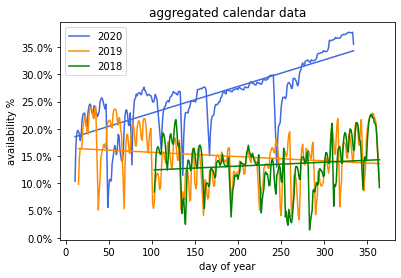

In [25]:
def predict_linear_regression(series):
    '''
    Description: computes a linear regression for 1d (x,y) value pairs.
    
    Arguments:
        series (pandas.Series): pandas Series with number values. The index will be used as the x-values.
    
    Returns:
        ([number],[number]): tuple of two lists for x and y values.
    '''
    linear_regression = LinearRegression()
    X = series.index.values.reshape(-1,1)
    Y = series.values.reshape(-1,1)
    linear_regression.fit(X,Y)
    return (X,linear_regression.predict(X))

# group by day of year to plot function for different years comparable together in 1 plot
cg2020 = calendar2020.groupby('dayofyear')
cg2019 = calendar2019.groupby('dayofyear')
cg2018 = calendar2018.groupby('dayofyear')
ax = cg2020.obtainable.mean().plot(label="2020", legend=True, color='royalblue')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# also plot the corresponding linear regression line
plt.plot(*predict_linear_regression(cg2020.obtainable.mean()), color='royalblue')
cg2019.obtainable.mean().plot(label="2019", legend=True, color='darkorange')
plt.plot(*predict_linear_regression(cg2019.obtainable.mean()), color='darkorange')
cg2018.obtainable.mean().plot(label="2018", legend=True, color='green')
plt.plot(*predict_linear_regression(cg2018.obtainable.mean()), color='green')

plt.title('aggregated calendar data')
plt.xlabel('day of year')
plt.ylabel('availability %')
plt.gcf().savefig('day_of_year_availability.png', bbox_inches='tight')

plt.show()

The overall availability plotted for the two years before 2020 clearly show the same pattern. A simple linear regression line indicates that the year 2020 is definetly different. Apart from a greater gradient we can visually see that the availability of accommodation is up to 25% where the years before it is about 15%.

let's try to find out if in 2020 people have given priority to amenities

## Evaluation

In [35]:
# read in listing data which contains the list of amenities
listings2020 = pd.read_csv('data/2020-08-30/unzipped/listings.csv')
listings2019 = pd.read_csv('data/2019-12-11/unzipped/listings.csv')
listings2018 = pd.read_csv('data/2018-12-10/unzipped/listings.csv')

In [27]:
import json

def convert_to_float(value):
    '''
    Description: converts a string value to a float number.
    
    Arguments:
        value (str): a string representing a valid fload number.
    
    Returns:
        (float): converted float value
    '''
    if isinstance(value, float):
        return value
    else:
        return float(value.replace('$','').replace(',',''))
    
def combine_amenities_and_availability(listings, calendar, json_format=True):
    '''
    Description: creates a new dataset with from the combination of Inside Airbnb listing.csv and calendar.csv datasets.
                 From the listings dataset it derives boolean columns for the types of accommodation.
                 It then adds the availability and price values from the calendar dataset.
    
    Arguments:
        listings (pandas.DataFrame): dataset of Inside Airbnb listings.csv file.
        calendar (pandas.DataFrame): dataset of Inside Airbnb calendar.csv file.
        json_format (bool): flag indicating if the amenities are encoded in json_format
    
    Returns:
        (pandas.DataFrame): the combined new dataset for analyzing amenities.
    '''
    amenities = listings[['id','amenities']] # we only analize amenites, drop the rest
    # amenities of an accomodation/listing are encoded in one cell value. We need to extract the information...
    # After extractions every amenity is marked for existence in a new boolean column
    if json_format:
        amenities = pd.concat([amenities,
          # in 2020 the data is in valid json format
          amenities.amenities.apply(lambda x: ','.join(json.loads(x))).str.get_dummies(sep=',')
          ],axis=1)
    else:
        amenities = pd.concat([amenities,
          # before 2020 the data contains some weird array syntax, hard to parse, so we use string regexes
          amenities.amenities.str.replace('[{}"]','',regex=True).str.get_dummies(sep=',')
          ],axis=1)            
    # now the actual merge with the obtainale value of the calendar dataframe
    amenities = pd.merge(amenities, calendar[['listing_id','obtainable','price']], left_on='id', right_on='listing_id', how='left')
    amenities.drop(columns=['amenities','listing_id'], axis=1, inplace=True)
    amenities.dropna(subset=['obtainable','price'], inplace=True)
    amenities.price = amenities.price.apply(convert_to_float)
    return amenities


In [28]:
#amenities2020 = combine_amenities_and_availability(listings2020[listings2020.id.isin(covid_listings)], calendar2020)
#amenities2019 = combine_amenities_and_availability(listings2019[listings2019.id.isin(covid_listings)], calendar2019, json_format=False)
#amenities2018 = combine_amenities_and_availability(listings2018[listings2018.id.isin(covid_listings)], calendar2018, json_format=False)

In [29]:
# read in amenities
amenities2020 = combine_amenities_and_availability(listings2020, calendar2020)
amenities2019 = combine_amenities_and_availability(listings2019, calendar2019, json_format=False)
amenities2018 = combine_amenities_and_availability(listings2018, calendar2018, json_format=False)

In [30]:
def compute_correlation_matrix(amenities):
    '''
    Description: computes the correlation matrix of the given numeric dataset and a corresponding
                 boolean matrix which can be used to hide the upper triangular part of the matrix during plotting.
    
    Arguments:
        amenities (pandas.DataFrame): a dataset containing amenities with numeric encoding
    
    Returns:
        (pandas.DataFrame,[[int]]): the combined new dataset for analyzing amenities and the corresponding
                                    boolean mask.
    '''
    no_id = amenities.drop(columns=['id'])
    # corr = 1-pairwise_distances(no_id.T, metric = "hamming")
    # corr = pd.DataFrame(corr, index=no_id.columns, columns=no_id.columns)
    corr = no_id.corr()
    # mask the upper triangle of the correlation matrix. 
    mask = np.triu(np.ones_like(corr, dtype=bool))
    return (corr,mask)

def plot_and_save_correlation(corr,mask, filename):
    '''
    Description: plots a correlation matrix and saves the plot to the filesystem.
    
    Arguments:
        corr (pandas.DataFrame): dataset containing a correlation matrix.
        mask ([[int]]): helper matrix to hide the upper triangular part of the matrix in the plot.
        filename: name of resulting plot file.
    
    Returns:
        None
    '''
    plt.figure(figsize=(8, 8))
    svm = sns.heatmap(corr, mask=mask, annot=True)
    figure = svm.get_figure()
    figure.savefig(filename, bbox_inches='tight')
    plt.show()

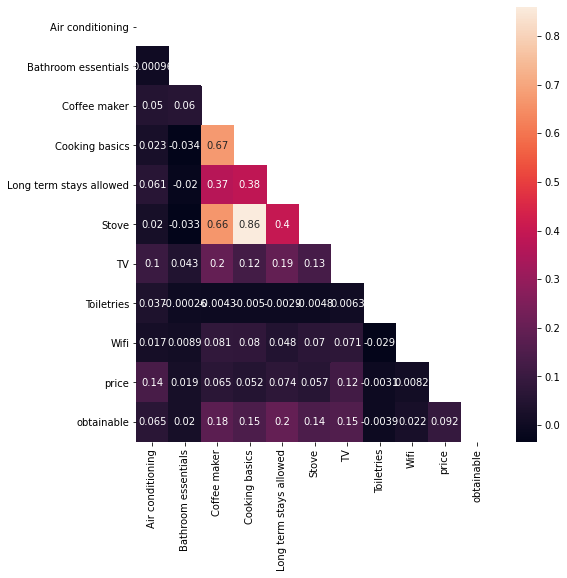

In [31]:
# plot the correlation matrix for 2020
cor_columns2020 = ['id', 'Air conditioning', 'Bathroom essentials', 'Coffee maker', 'Cooking basics', 'Long term stays allowed', 'Stove', 'TV', 'Toiletries', 'Wifi', 'price', 'obtainable']
plot_and_save_correlation(*compute_correlation_matrix(amenities2020[cor_columns2020]),'corr2020.png')


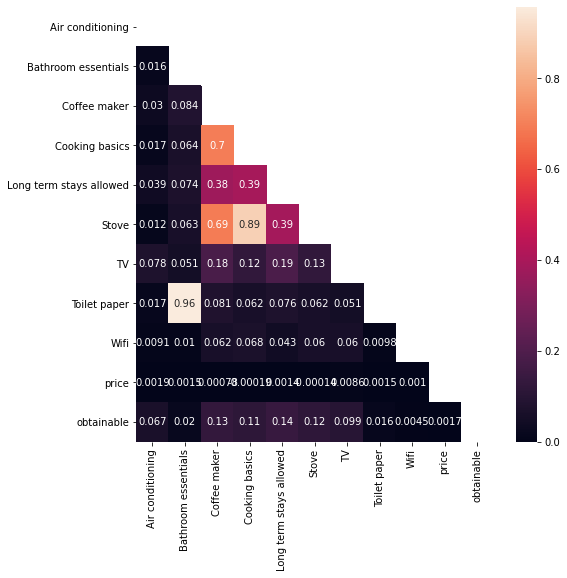

In [32]:
# plot the correlation matrix for 2019
cor_columns2019 = ['id', 'Air conditioning', 'Bathroom essentials', 'Coffee maker', 'Cooking basics', 'Long term stays allowed', 'Stove', 'TV', 'Toilet paper', 'Wifi', 'price', 'obtainable']
plot_and_save_correlation(*compute_correlation_matrix(amenities2019[cor_columns2019]),'corr2019.png')


In [33]:
# the end.